In [1]:
# Jonathan Markey - 1805361, 29/09/23

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score
from tabulate import tabulate
from tqdm import tqdm

%matplotlib inline

In [2]:
data = pd.read_csv('diabetes.csv') # Importing data as csv

cols = data.columns

for i in cols: # preprocessing to normalise between [-1,1]
    data[cols] = (data[cols]-np.min(data[cols]))/(np.max(data[cols])-np.min(data[cols]))
    data[cols] = 2*data[cols]-1

outcome = data['Outcome'].values
data = data.drop("Outcome", axis = 1)
data = data.values

x_train, x_test, y_train, y_test = train_test_split(data, outcome, test_size = 0.3, random_state = 1234) # train/test split at 70/30 ratio

x_train = torch.tensor(x_train, dtype = torch.float32)
x_test = torch.tensor(x_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype = torch.float32).view(-1, 1)

c:\Users\jono_\UniWork\.conda\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jono_\UniWork\.conda\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jono_\UniWork\.conda\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jono_\UniWork\.conda\Lib\site-package

In [3]:
class Perceptron():
    def __init__(self, n_features): # initialisation of the Perceptron class. Input of number of features which equals 8 in this example
        self.weights = torch.rand(n_features, 1, dtype=torch.float32) # Weights and bias initialised as random values
        self.bias = torch.rand(1, dtype=torch.float32)
        
    def forward(self, x_data): # The forward function solves the linear equation
        linear_eq = torch.mm(x_data, self.weights) + self.bias # solves the linear equation W_i * X_i + b
        activation = torch.sign(linear_eq) # activation function to return binary output
        return activation, linear_eq
    
    def backward(self, x_data, y_data, learning_rate): # Backwards propagation/training
        pred, lin_eq = self.forward(x_data) # getting results from the forward pass
        
        loss = torch.clamp(-(y_data)*lin_eq, min=0) # calculating perceptron loss
        perceptron_loss = torch.mean(loss)
        
        temp = torch.where(y_data == pred, 0, 1) # Xor gate
        
        gradient_weights = torch.mm(x_data.t(), -y_data * temp) # implamenting gradient descent to optimise the weights and bias
        self.weights -= learning_rate * gradient_weights
        gradient_bias = torch.sum(-y_data * temp)
        self.bias -= learning_rate * gradient_bias
        
        return perceptron_loss.item()  # Returning the loss value so that it can be graphed

In [4]:
torch.manual_seed(999) # setting seeed value for reproduceability
n_features = len(x_train[0])
learning_rate = 0.01

model = Perceptron(n_features) # defining perceptron class

n_iterations = 1000

loss_track = [] # for tracking mean perceptron loss

for i in tqdm(range(n_iterations)): # training loop for model
    loss_value = model.backward(x_train, y_train, learning_rate) 
    if i % 10 == 0:
        loss_track.append(loss_value)
        
prediction_train, lq_train = model.forward(x_train) # predicting training data
prediction_test, lq_test = model.forward(x_test) # predicting testing data

loss_track = np.array(loss_track)
x_axis = [i for i in range(len(loss_track))]

100%|██████████| 1000/1000 [00:00<00:00, 7685.34it/s]


Text(0.5, 1.0, 'Perceptron Loss at N Iterations')

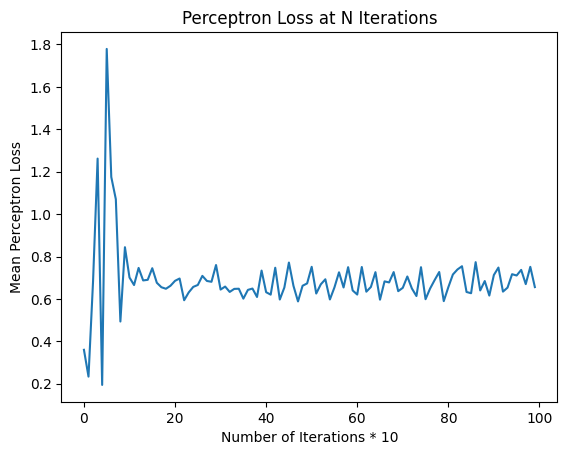

In [5]:
plt.plot(x_axis, loss_track) # plotting mean perceptron loss
plt.xlabel("Number of Iterations * 10")
plt.ylabel("Mean Perceptron Loss")
plt.title("Perceptron Loss at N Iterations")

In [6]:
# Evaluation stats for training data

confusion = confusion_matrix(y_train, prediction_train)
headers = ["Predicted -1", "Predicted 1"]
table = [["True -1", confusion[0, 0], confusion[0, 1]],
         ["True 1", confusion[1, 0], confusion[1, 1]]]

print("Training Confusion Matrix:")
print(tabulate(table, headers),'\n')

print("Training Evaluation")
accuracy_train = accuracy_score(y_train, prediction_train)
spec_train = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
sens_train = recall_score(y_train, prediction_train)
pre_train = precision_score(y_train, prediction_train)
f1_train = f1_score(y_train, prediction_train)
print(f"Accuracy: {accuracy_train}")
print(f"Specificity: {spec_train}")
print(f"Sensitivity: {sens_train}")
print(f"Precision: {pre_train}")
print(f"F1-Score: {f1_train}")
auc_roc_train = roc_auc_score(y_train, prediction_train)
print(f"AUC ROC: {auc_roc_train}")

Training Confusion Matrix:
           Predicted -1    Predicted 1
-------  --------------  -------------
True -1             344              9
True 1              139             45 

Training Evaluation
Accuracy: 0.7243947858472998
Specificity: 0.9745042492917847
Sensitivity: 0.24456521739130435
Precision: 0.8333333333333334
F1-Score: 0.3781512605042017
AUC ROC: 0.6095347333415445


In [7]:
# Evaluation stats for testing data

confusion = confusion_matrix(y_test, prediction_test)
headers = ["Predicted -1", "Predicted 1"]
table = [["True -1", confusion[0, 0], confusion[0, 1]],
         ["True 1", confusion[1, 0], confusion[1, 1]]]

print("Testing Confusion Matrix:")
print(tabulate(table, headers),'\n')

print("Testing Evaluation")
accuracy_test = accuracy_score(y_test, prediction_test)
spec_test = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
sens_test = recall_score(y_test, prediction_test)
pre_test = precision_score(y_test, prediction_test)
f1_test = f1_score(y_test, prediction_test)
print(f"Accuracy: {accuracy_test}")
print(f"Specificity: {spec_test}")
print(f"Sensitivity: {sens_test}")
print(f"Precision: {pre_test}")
print(f"F1-Score: {f1_test}")
auc_roc_test = roc_auc_score(y_test, prediction_test)
print(f"AUC ROC: {auc_roc_test}")

Testing Confusion Matrix:
           Predicted -1    Predicted 1
-------  --------------  -------------
True -1             145              2
True 1               62             22 

Testing Evaluation
Accuracy: 0.7229437229437229
Specificity: 0.9863945578231292
Sensitivity: 0.2619047619047619
Precision: 0.9166666666666666
F1-Score: 0.4074074074074074
AUC ROC: 0.6241496598639455


In [8]:
table = [["Accuracy", accuracy_train, accuracy_test],["Specificity",spec_train, spec_test],["Sensitivity",sens_train,sens_test],
         ["Precision", pre_train, pre_test],["F1-Score", f1_train, f1_test],
         ["AUC-ROC",auc_roc_train, auc_roc_test]]
headers = ["Training", "Testing"]
print(tabulate(table, headers))

               Training    Testing
-----------  ----------  ---------
Accuracy       0.724395   0.722944
Specificity    0.974504   0.986395
Sensitivity    0.244565   0.261905
Precision      0.833333   0.916667
F1-Score       0.378151   0.407407
AUC-ROC        0.609535   0.62415
